In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import ListedColormap
import seaborn as sns
from cycler import cycler
from IPython.display import display
import datetime

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_classif

plt.rcParams['axes.facecolor'] = '#0057b8' # blue
plt.rcParams['axes.prop_cycle'] = cycler(color=['#ffd700'] +
                                         plt.rcParams['axes.prop_cycle'].by_key()['color'][1:])

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

print()
print('Train')
display(train.head(3))

print()
print('Test')
display(test.head(3))

print('Dataframe shapes:', train.shape, test.shape)
print()


Train


,id,f_00,f_01,f_02,f_03,f_04,f_05,f_06,f_07,f_08,...,f_22,f_23,f_24,f_25,f_26,f_27,f_28,f_29,f_30,target
0,0,-1.373246,0.238887,-0.243376,0.567405,-0.647715,0.839326,0.113133,1,5,...,-2.540739,0.766952,-2.730628,-0.208177,1.363402,ABABDADBAB,67.609153,0,0,0
1,1,1.697021,-1.710322,-2.230332,-0.545661,1.113173,-1.552175,0.447825,1,3,...,2.278315,-0.633658,-1.217077,-3.782194,-0.058316,ACACCADCEB,377.096415,0,0,1
2,2,1.681726,0.616746,-1.027689,0.810492,-0.609086,0.113965,-0.708660,1,0,...,-1.385775,-0.520558,-0.009121,2.788536,-3.703488,AAAEABCKAD,-195.599702,0,2,1



Test


,id,f_00,f_01,f_02,f_03,f_04,f_05,f_06,f_07,f_08,...,f_21,f_22,f_23,f_24,f_25,f_26,f_27,f_28,f_29,f_30
0,900000,0.442517,0.174380,-0.999816,0.762741,0.186778,-1.074775,0.501888,6,6,...,-1.006400,-1.193879,-2.435736,-2.427430,-1.966887,5.734205,BAAABADLAC,99.478419,0,0
1,900001,-0.605598,-0.305715,0.627667,-0.578898,-1.750931,1.355550,-0.190911,1,3,...,2.382405,0.149442,1.883322,-2.848714,-0.725155,3.194219,AFABBAEGCB,-65.993825,1,0
2,900002,0.303990,2.445110,0.246515,0.818248,0.359731,-1.331845,1.358622,3,3,...,-7.026098,1.312277,-5.157192,1.714005,0.585032,0.066898,BBACABBKEE,-87.405622,0,1


Dataframe shapes: (900000, 33) (700000, 32)



In [3]:
train_copied = train.copy()
test_copied = test.copy()
def load_data():
    train = train_copied.copy()
    test = test_copied.copy()
    return train,test

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900000 entries, 0 to 899999
Data columns (total 33 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   id      900000 non-null  int64  
 1   f_00    900000 non-null  float64
 2   f_01    900000 non-null  float64
 3   f_02    900000 non-null  float64
 4   f_03    900000 non-null  float64
 5   f_04    900000 non-null  float64
 6   f_05    900000 non-null  float64
 7   f_06    900000 non-null  float64
 8   f_07    900000 non-null  int64  
 9   f_08    900000 non-null  int64  
 10  f_09    900000 non-null  int64  
 11  f_10    900000 non-null  int64  
 12  f_11    900000 non-null  int64  
 13  f_12    900000 non-null  int64  
 14  f_13    900000 non-null  int64  
 15  f_14    900000 non-null  int64  
 16  f_15    900000 non-null  int64  
 17  f_16    900000 non-null  int64  
 18  f_17    900000 non-null  int64  
 19  f_18    900000 non-null  int64  
 20  f_19    900000 non-null  float64
 21  f_20    90

In [5]:
(train.target.value_counts() / len(train)).round(2)

0    0.51
1    0.49
Name: target, dtype: float64

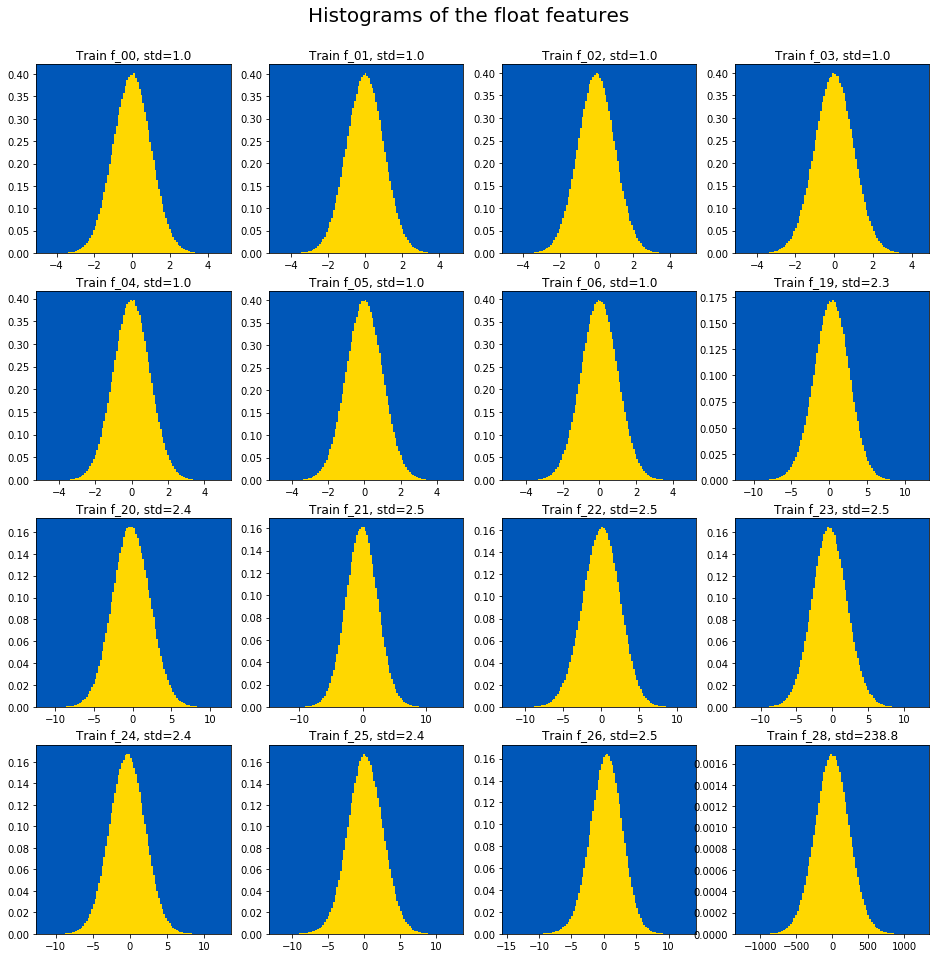

In [6]:
float_features = [f for f in train.columns if train[f].dtype == 'float64']

# Training histograms
fig, axs = plt.subplots(4, 4, figsize=(16, 16))
for f, ax in zip(float_features, axs.ravel()):
    ax.hist(train[f], density=True, bins=100)
    ax.set_title(f'Train {f}, std={train[f].std():.1f}')
plt.suptitle('Histograms of the float features', y=0.93, fontsize=20)
plt.show()

# Test histograms
# fig, axs = plt.subplots(4, 4, figsize=(16, 16))
# for f, ax in zip(float_features, axs.ravel()):
#     ax.hist(test[f], density=True, bins=100)
#     ax.set_title(f'Test {f}, std={test[f].std():.1f}')
# plt.show()

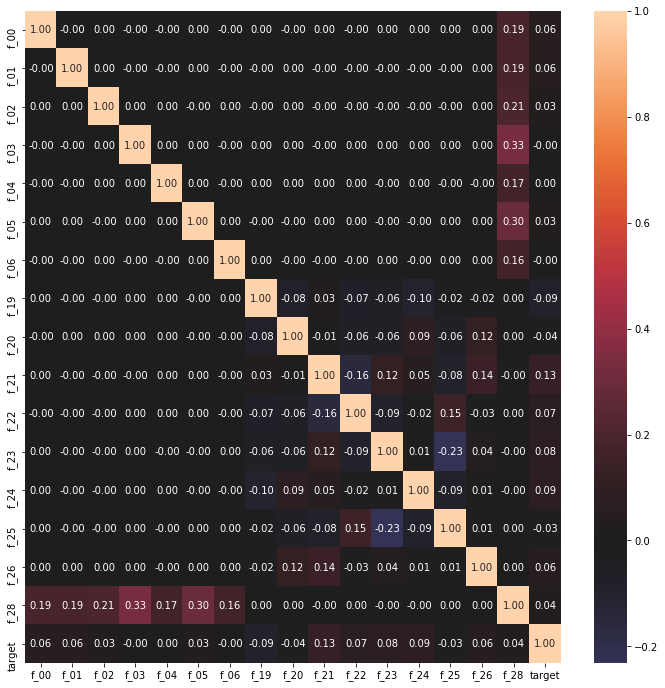

In [7]:
# Correlation matrix of the float features
plt.figure(figsize=(12, 12))
sns.heatmap(train[float_features + ['target']].corr(), center=0, annot=True, fmt='.2f')
plt.show()


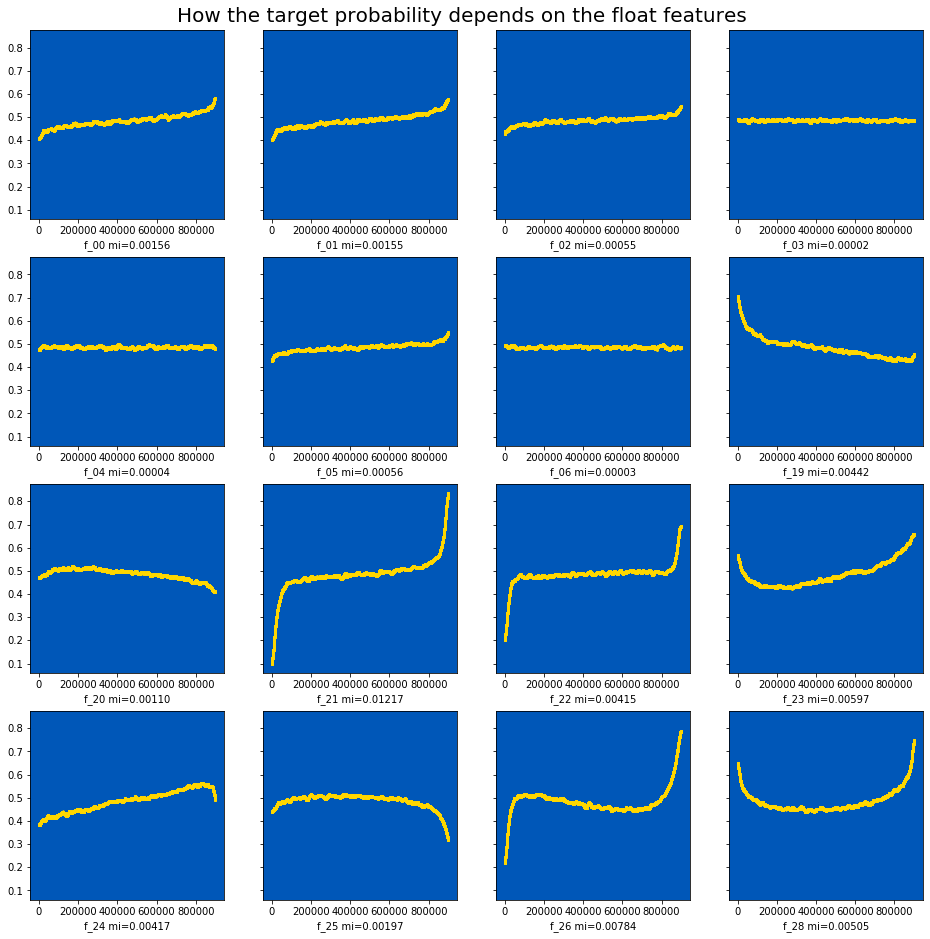

In [8]:
# Plot dependence between every feature and the target
def plot_mutual_info_diagram(df, features, ncols=4, by_quantile=True, mutual_info=True,
                             title='How the target probability depends on single features'):
    def H(p):
        """Entropy of a binary random variable in nat"""
        return -np.log(p) * p - np.log(1-p) * (1-p)
                 
    nrows = (len(features) + ncols - 1) // ncols
    fig, axs = plt.subplots(nrows, ncols, figsize=(16, nrows*4), sharey=True)
    for f, ax in zip(features, axs.ravel()):
        temp = pd.DataFrame({f: df[f].values,
                             'state': df.target.values})
        temp = temp.sort_values(f)
        temp.reset_index(inplace=True)
        rolling_mean = temp.state.rolling(15000, center=True, min_periods=1).mean()
        if by_quantile:
            ax.scatter(temp.index, rolling_mean, s=2)
        else:
            ax.scatter(temp[f], rolling_mean, s=2)
        if mutual_info and by_quantile:
            ax.set_xlabel(f'{f} mi={H(temp.state.mean()) - H(rolling_mean[~rolling_mean.isna()].values).mean():.5f}')
        else:
            ax.set_xlabel(f'{f}')
    plt.suptitle(title, y=0.90, fontsize=20)
    plt.show()

plot_mutual_info_diagram(train, float_features,
                         title='How the target probability depends on the float features')

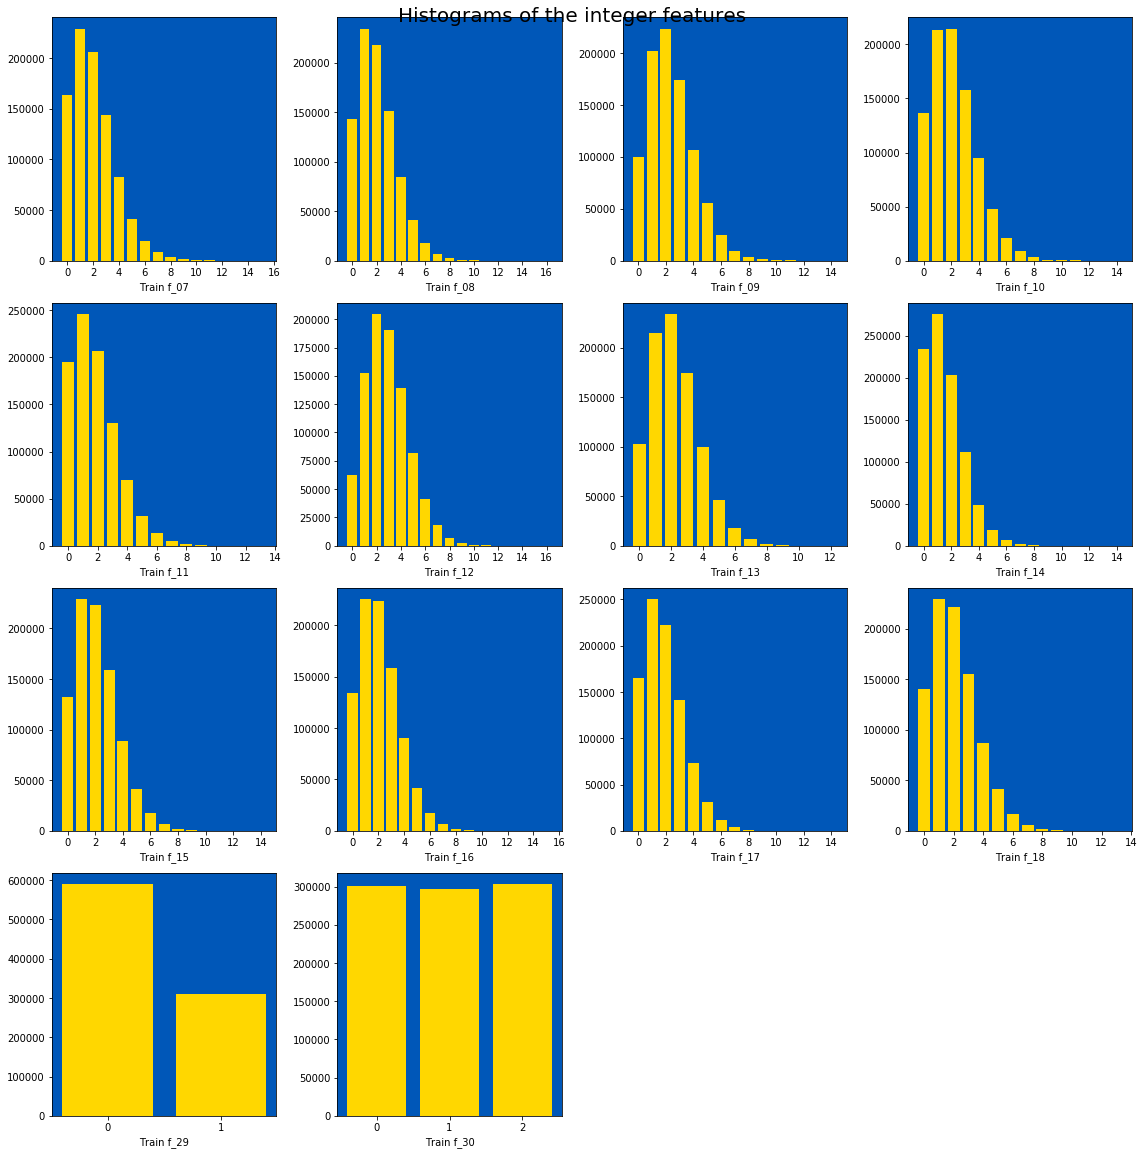

In [9]:
int_features = [f for f in test.columns if test[f].dtype == 'int64' and f != 'id']

# Training histograms
#fig, axs = plt.subplots(4, 4, figsize=(16, 16))
figure = plt.figure(figsize=(16, 16))
# for f, ax in zip(int_features, axs.ravel()):
for i, f in enumerate(int_features):
    plt.subplot(4, 4, i+1)
    ax = plt.gca()
    vc = train[f].value_counts()
    ax.bar(vc.index, vc)
    #ax.hist(train[f], density=False, bins=(train[f].max()-train[f].min()+1))
    ax.set_xlabel(f'Train {f}')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True)) # only integer labels
plt.suptitle('Histograms of the integer features', y=1.0, fontsize=20)
figure.tight_layout(h_pad=1.0)
plt.show()

# Test histograms
# fig, axs = plt.subplots(4, 4, figsize=(16, 16))
# for f, ax in zip(int_features, axs.ravel()):
#     ax.hist(test[f], density=True, bins=100)
#     ax.set_title(f'Test {f}, std={test[f].std():.1f}')
# plt.show()

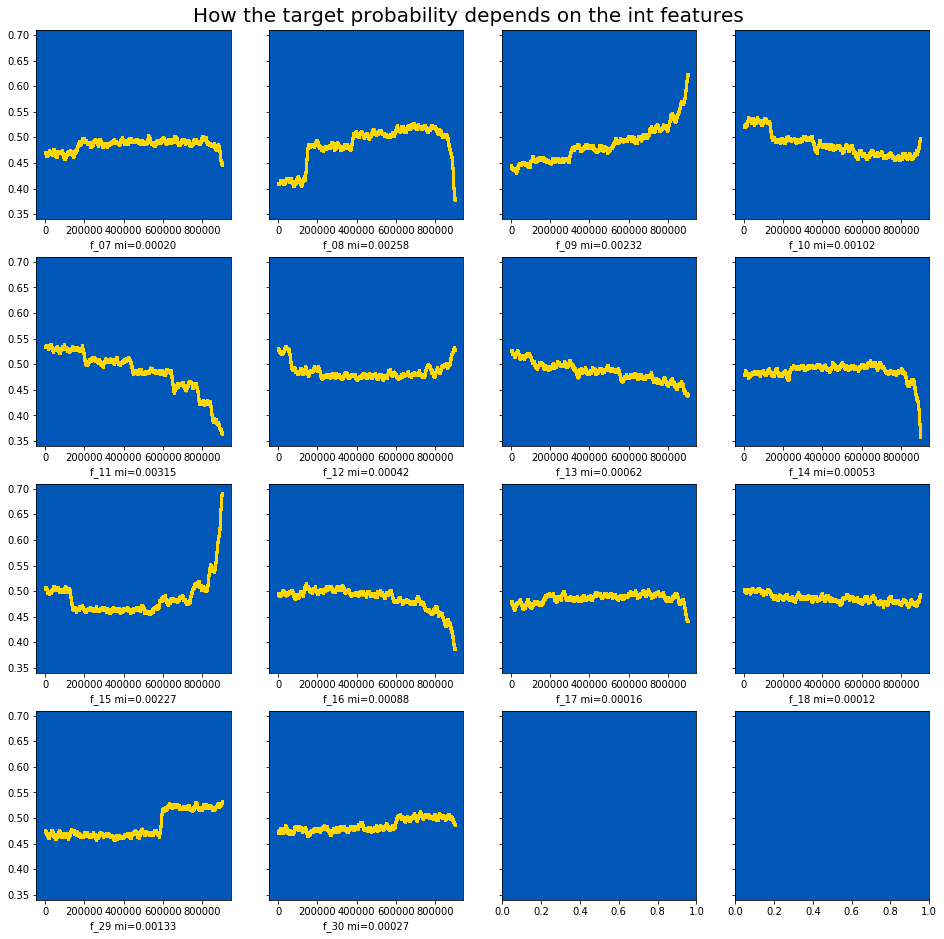

In [10]:
plot_mutual_info_diagram(train, int_features,
                         title='How the target probability depends on the int features')

In [11]:
train.f_27.str.len().min(), train.f_27.str.len().max(), test.f_27.str.len().min(), test.f_27.str.len().max()

(10, 10, 10, 10)

In [12]:
train.f_27.value_counts()

BCBBBBCLBC    12
BBBBBBCJBC    12
ADBBBACQBC    10
BBBBBABLCB    10
BBBBBBDPCB    10
              ..
ABBBBABFBH     1
ACABBAHABC     1
BBADDBBPEB     1
BEBCDBGGCA     1
ABBEBAFOCD     1
Name: f_27, Length: 741354, dtype: int64

In [13]:
pd.concat([train, test]).f_27.value_counts()

ACBBAABCBC    15
BAAACABNBC    15
BAAACABLBB    15
BCBBBBCDCC    14
BCBBBBCLBC    13
              ..
ADBBABATCA     1
BBBDCACRAB     1
AIBDBBEICC     1
AEBCCABDCC     1
ABBEBAFOCD     1
Name: f_27, Length: 1181880, dtype: int64

In [14]:
for i in range(10):
    print(f'Position {i}')
    tg = train.groupby(train.f_27.str.get(i))
    temp = pd.DataFrame({'size': tg.size(), 'probability': tg.target.mean().round(2)})
    print(temp)
    print()

Position 0
        size  probability
f_27                     
A     451207         0.54
B     448793         0.44

Position 1
        size  probability
f_27                     
A     144762         0.58
B     245160         0.48
C     225931         0.49
D     149579         0.45
E      78807         0.43
F      35487         0.42
G      13713         0.41
H       4647         0.40
I       1361         0.40
J        410         0.38
K        113         0.39
L         25         0.28
M          3         0.67
N          2         1.00

Position 2
        size  probability
f_27                     
A     297840         0.53
B     602160         0.46

Position 3
        size  probability
f_27                     
A     160839         0.57
B     237218         0.48
C     210015         0.48
D     143633         0.45
E      81662         0.43
F      39504         0.44
G      17121         0.45
H       6473         0.47
I       2379         0.48
J        772         0.51
K        254     

In [15]:
unique_characters = train.f_27.apply(lambda s: len(set(s))).rename('unique_characters')
tg = train.groupby(unique_characters)
temp = pd.DataFrame({'size': tg.size(), 'probability': tg.target.mean().round(2)})
print(temp)

                     size  probability
unique_characters                     
1                       1         0.00
2                    1092         0.09
3                   32164         0.09
4                  211165         0.48
5                  399974         0.49
6                  220715         0.48
7                   33698         0.91
8                    1185         0.91
9                       6         1.00


In [16]:
for df in [train, test]:
    for i in range(10):
        df[f'ch{i}'] = df.f_27.str.get(i).apply(ord) - ord('A')
    df["unique_characters"] = df.f_27.apply(lambda s: len(set(s)))

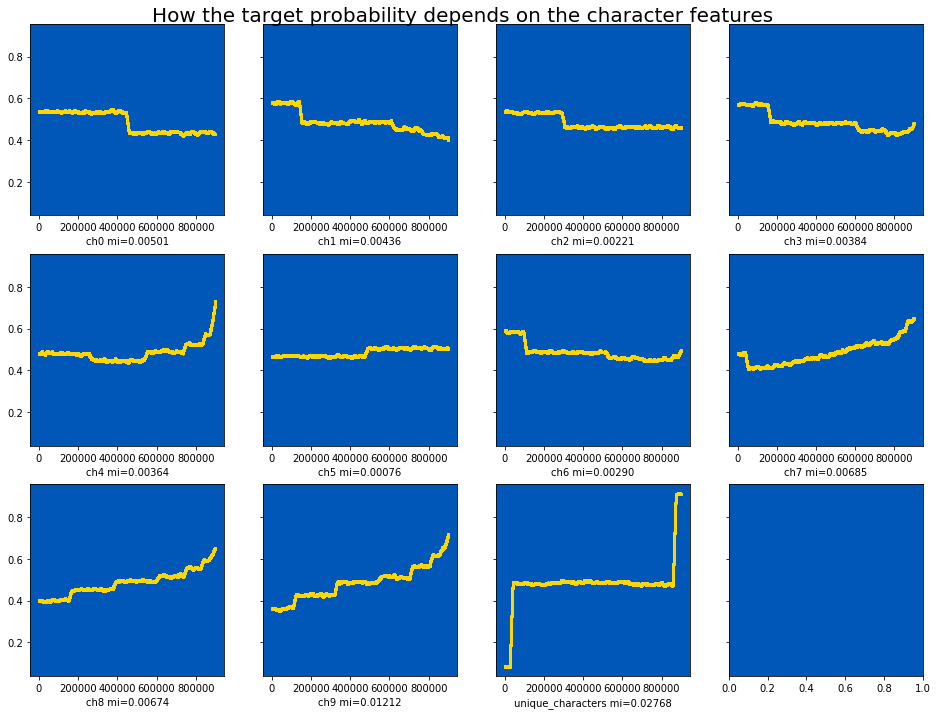

In [17]:
plot_mutual_info_diagram(train, 
                         [f for f in train.columns if f.startswith('ch')] + ['unique_characters'],
                         title='How the target probability depends on the character features')

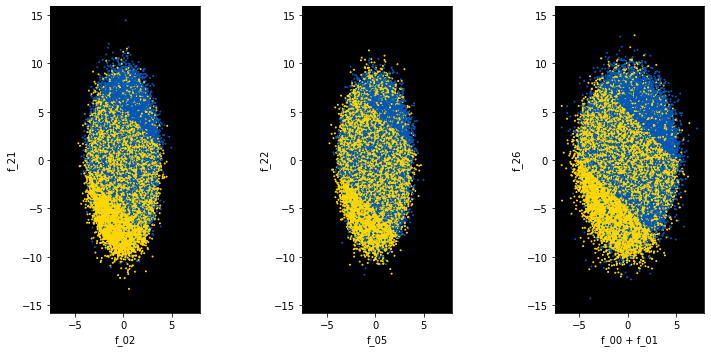

In [18]:
plt.rcParams['axes.facecolor'] = 'k'
plt.figure(figsize=(11, 5))
cmap = ListedColormap(["#ffd700", "#0057b8"])
# target == 0 → yellow; target == 1 → blue

ax = plt.subplot(1, 3, 1)
ax.scatter(train['f_02'], train['f_21'], s=1,
           c=train.target, cmap=cmap)
ax.set_xlabel('f_02')
ax.set_ylabel('f_21')
ax.set_aspect('equal')
ax0 = ax

ax = plt.subplot(1, 3, 2, sharex=ax0, sharey=ax0)
ax.scatter(train['f_05'], train['f_22'], s=1,
           c=train.target, cmap=cmap)
ax.set_xlabel('f_05')
ax.set_ylabel('f_22')
ax.set_aspect('equal')

ax = plt.subplot(1, 3, 3, sharex=ax0, sharey=ax0)
ax.scatter(train['f_00'] + train['f_01'], train['f_26'], s=1,
           c=train.target, cmap=cmap)
ax.set_xlabel('f_00 + f_01')
ax.set_ylabel('f_26')
ax.set_aspect('equal')

plt.tight_layout(w_pad=1.0)
plt.savefig('three-projections.png')
plt.show()
plt.rcParams['axes.facecolor'] = '#0057b8' # blue

In [19]:
for df in [train, test]:
    df['i_02_21'] = (df.f_21 + df.f_02 > 5.2).astype(int) - (df.f_21 + df.f_02 < -5.3).astype(int)
    df['i_05_22'] = (df.f_22 + df.f_05 > 5.1).astype(int) - (df.f_22 + df.f_05 < -5.4).astype(int)
    i_00_01_26 = df.f_00 + df.f_01 + df.f_26
    df['i_00_01_26'] = (i_00_01_26 > 5.0).astype(int) - (i_00_01_26 < -5.0).astype(int)

In [20]:
feature_drop = ['f_03','f_04','f_06','f_18','f_30','f_27']
for df in [train,test]:
    df.drop(feature_drop,axis = 1, inplace = True)

In [21]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900000 entries, 0 to 899999
Data columns (total 41 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 900000 non-null  int64  
 1   f_00               900000 non-null  float64
 2   f_01               900000 non-null  float64
 3   f_02               900000 non-null  float64
 4   f_05               900000 non-null  float64
 5   f_07               900000 non-null  int64  
 6   f_08               900000 non-null  int64  
 7   f_09               900000 non-null  int64  
 8   f_10               900000 non-null  int64  
 9   f_11               900000 non-null  int64  
 10  f_12               900000 non-null  int64  
 11  f_13               900000 non-null  int64  
 12  f_14               900000 non-null  int64  
 13  f_15               900000 non-null  int64  
 14  f_16               900000 non-null  int64  
 15  f_17               900000 non-null  int64  
 16  f_

In [26]:
X = train.drop(['id','target'],axis = 1)
y = train['target']

In [27]:
from sklearn.model_selection import train_test_split
X_train,X_val,y_train,y_val = train_test_split(X,y,test_size = 0.2,random_state = 42)
X_test = test.drop(['id'],axis = 1)

In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,recall_score,precision_score
rf = RandomForestClassifier()
rf.fit(X_train,y_train)
y_val_pred = rf.predict(X_val)
print(f"Accuracy validation: {accuracy_score(y_val,y_val_pred)}")
print(f"Precision validation: {precision_score(y_val,y_val_pred)}")
print(f"Recall validation: {recall_score(y_val,y_val_pred)}")

Accuracy validation: 0.90345
Precision validation: 0.9165340679696963
Recall validation: 0.881761581081853


In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,recall_score,precision_score
rf = RandomForestClassifier()
rf.fit(X,y)
y_test = rf.predict_proba(X_test)

In [36]:
id = test['id']
df_submiss = pd.DataFrame({'id':id,'target':y_test[:,1]})
df_submiss.to_csv('submission.csv',index = False)